# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts accross multiple years.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

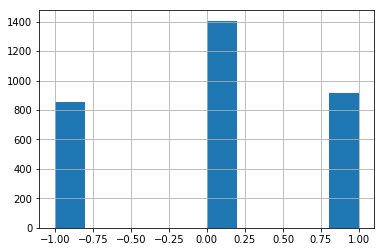

In [12]:
gold['target'].hist()

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

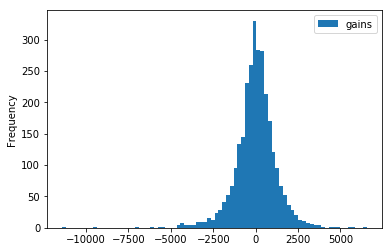

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')

### Investigate suitable stop-loss value

Below are cummulative curves

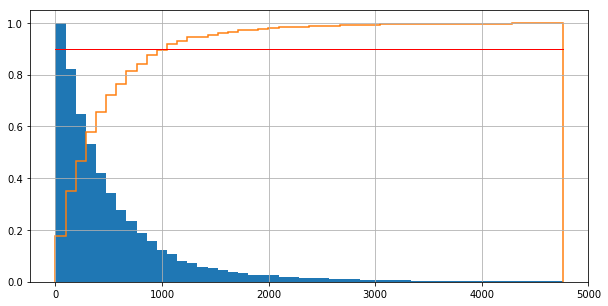

In [18]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

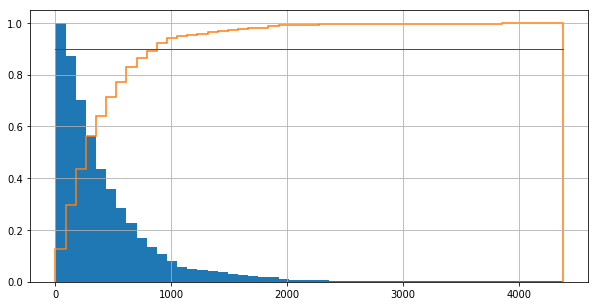

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')

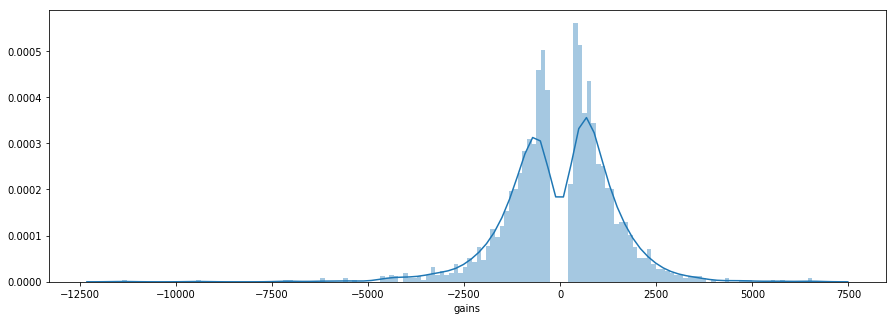

In [22]:
sr = gold_gains_train.loc[gold_gains_train.index < '2018-01-01'][gold_gains_train.gains.abs() > 300].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=150, ax=ax)

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

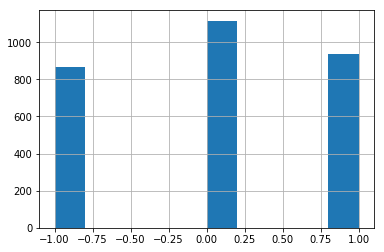

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.loc[corn.index < '2018-1-1'].target.hist()

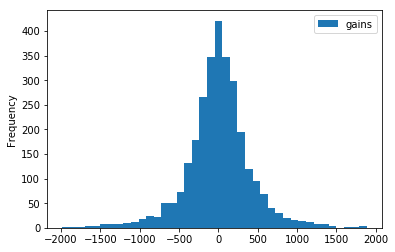

In [26]:
corn_gains_train[['gains']].plot.hist(bins=40)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

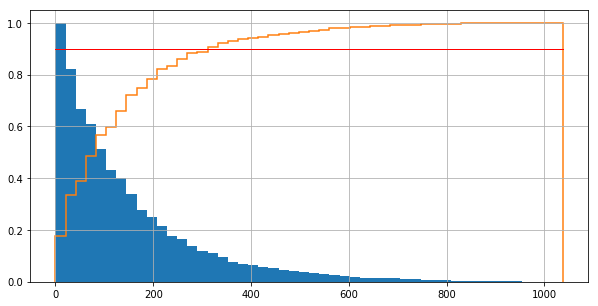

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')

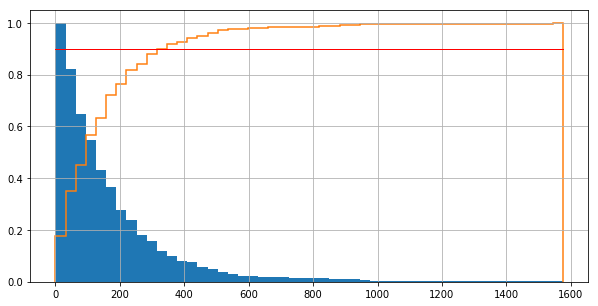

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


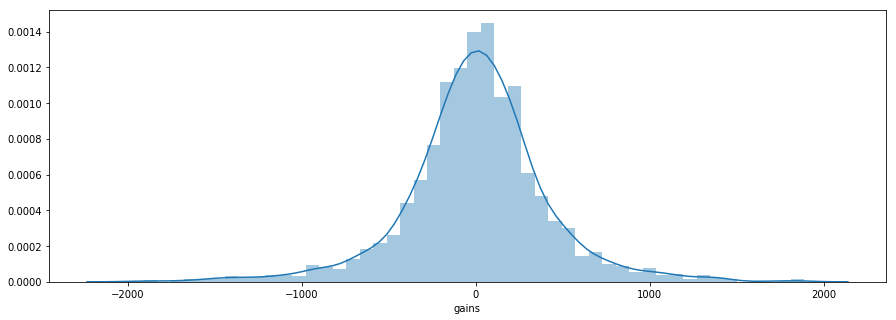

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, ax=ax)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


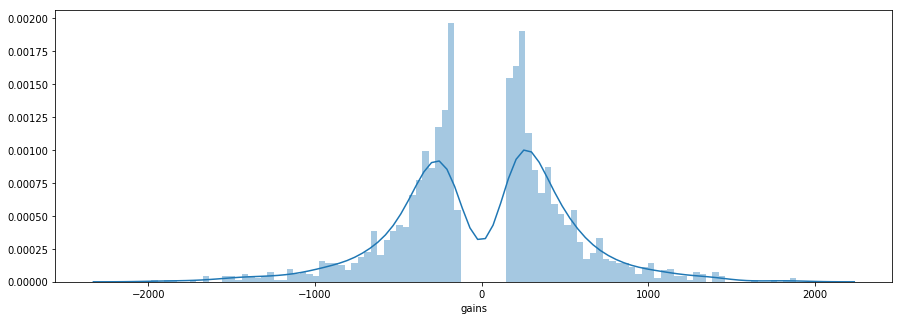

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

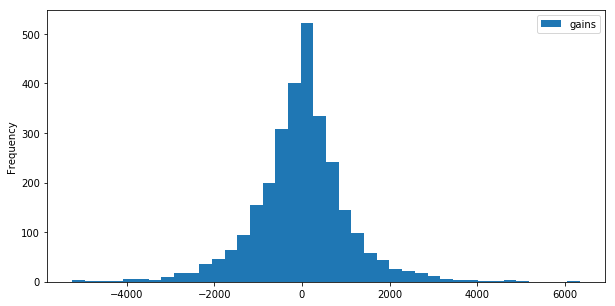

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

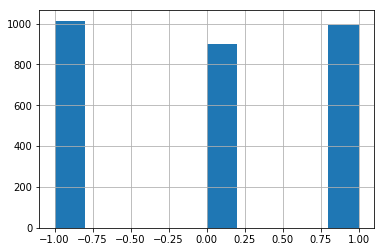

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.loc[coffee.index < '2018-1-1'].target.hist()

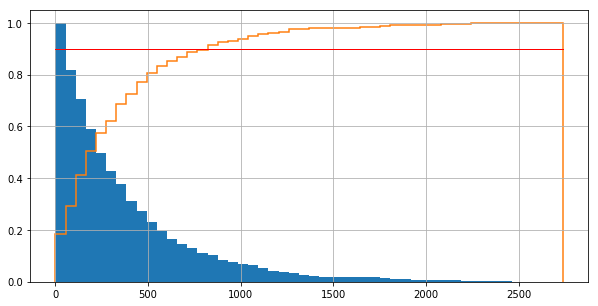

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')

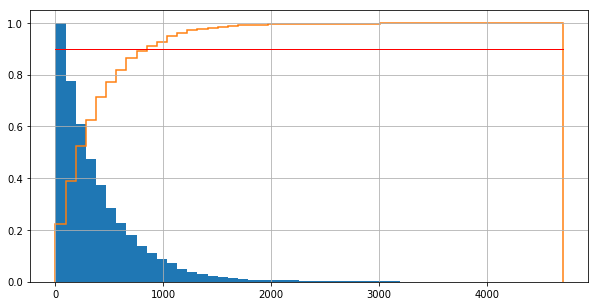

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')

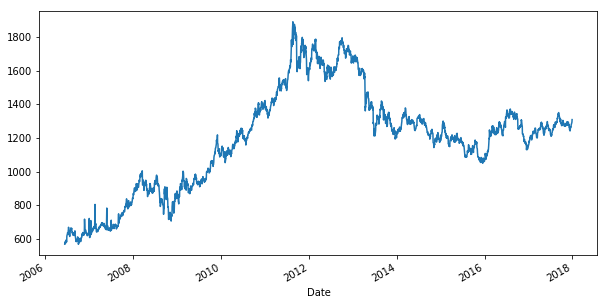

In [39]:
gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(10, 5))

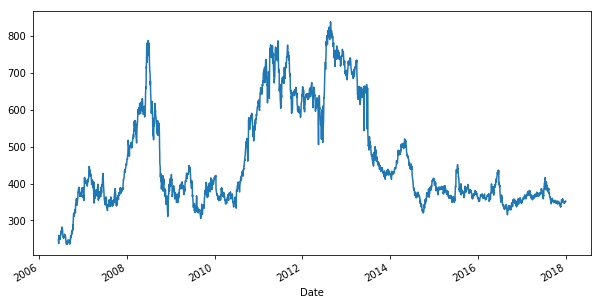

In [40]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

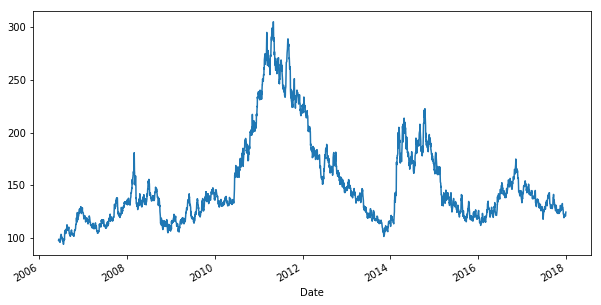

In [41]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

In [42]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [43]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [44]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,1175.1,1178.4,1162.2,1169.4,216866.0,...,0.139100,-0.951057,0.309017,-0.269797,0.962917,-5.000000e-01,0.866025,-1.0,-1.836970e-16,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,1174.3,1180.3,1168.4,1177.8,169593.0,...,0.139100,0.000000,1.000000,0.269797,0.962917,-2.449294e-16,1.000000,-1.0,-1.836970e-16,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,1182.6,1190.2,1158.6,1176.5,212507.0,...,0.139100,0.951057,0.309017,0.519584,0.854419,-2.449294e-16,1.000000,-1.0,-1.836970e-16,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,1172.8,1177.1,1168.1,1170.1,131034.0,...,0.275776,0.587785,-0.809017,0.730836,0.682553,-2.449294e-16,1.000000,-1.0,-1.836970e-16,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,1171.4,1182.3,1167.2,1177.5,138151.0,...,0.275776,-0.587785,-0.809017,0.887885,0.460065,-2.449294e-16,1.000000,-1.0,-1.836970e-16,1.0
2018-12-07,1171.4,1182.3,1167.2,1177.5,138151.0,1176.1,1180.7,1170.9,1172.4,142683.0,...,0.275776,-0.951057,0.309017,0.979084,0.203456,-2.449294e-16,1.000000,-1.0,-1.836970e-16,-1.0
2018-12-10,1176.1,1180.7,1170.9,1172.4,142683.0,1172.5,1173.8,1157.6,1161.9,154624.0,...,0.275776,0.000000,1.000000,0.997669,-0.068242,-2.449294e-16,1.000000,-1.0,-1.836970e-16,0.0
2018-12-11,1172.5,1173.8,1157.6,1161.9,154624.0,1161.4,1167.9,1152.5,1165.8,159925.0,...,0.275776,0.951057,0.309017,0.942261,-0.334880,-2.449294e-16,1.000000,-1.0,-1.836970e-16,0.0
2018-12-12,1161.4,1167.9,1152.5,1165.8,159925.0,1164.5,1167.0,1156.3,1159.0,136465.0,...,0.307822,0.587785,-0.809017,0.816970,-0.576680,-2.449294e-16,1.000000,-1.0,-1.836970e-16,0.0
2018-12-13,1164.5,1167.0,1156.3,1159.0,136465.0,1159.8,1168.0,1140.0,1163.7,206337.0,...,0.307822,-0.587785,-0.809017,0.631088,-0.775711,-2.449294e-16,1.000000,-1.0,-1.836970e-16,0.0


In [45]:
gold_data.shape

(2668, 2545)

In [46]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [47]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [48]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=80, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    # df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    return df_pca

In [49]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
# gold_train, gold_label_train, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [109]:
def create_pca_training(df, df_pca, name):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf.to_csv(name + '_long.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf.to_csv(name + '_short.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test.to_csv(name + '_short_test.csv', index=False)
    
    
create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

### Dimension reduction with PCA

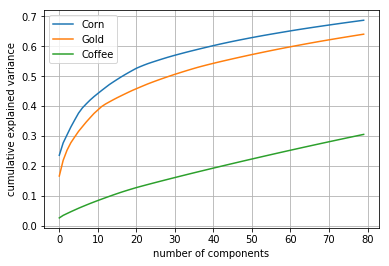

In [51]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
plt.show()

It is intereresting Corn is best expalined by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢

In [52]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [53]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [54]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.18.0-13-generic-x86_64-with-Ubuntu-18.10-cosmic


In [55]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [56]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, stop_loss_long=1000, stop_loss_short=800):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    predictions = []
    for v in preds:
        i = pd.Series(v).idxmax()
        # print(v, i)
        if i == 0:
            predictions.append(0)
        elif i == 1:
            predictions.append(-1)
        else:
            predictions.append(1)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800):
    global account_size, fee
    acc = account_size
    # print(preds)
    # print(np.unique(preds))
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    # print(np.unique(predictions))
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p, l)
        # print(p,l)
        # print(p)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            # print("Short ", acc, p, l, v)
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                # print("Stop loss hit!")
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            # print("Long ", acc, p, l, v)
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                # print("Stop loss hit!")
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
            # print("No trade ", acc, p, l, v)
        acc += gains
        # print("Acc ", acc)
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    return rf

In [57]:
%%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_train, gold_pca)
y = list(map(lambda x: 1 if x < 0 else 0, gold_label_train))
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, gold_label_test))
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

gold_short = True

param = {}
param['num_leaves'] = 40
param['objective'] = 'binary'
# param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
param['metric'] = 'ROC'
param['learning_rate'] = 0.1
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 50

gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [193]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=True, stop_loss=1000)
ax1 = gold_account[['account']].plot(grid=True)
ax1.set_ylim(0,gold_account.account.max()+500)

TypeError: get_performance() got an unexpected keyword argument 'short'

In [58]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [59]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
y = np.array(list(map(create_target, y.values)))
y_test = np.array(list(map(create_target, y_test.values)))

In [61]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers

input_shape = 80
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
opt = Nadam(lr=0.002)
model = define_model(input_shape, num_classes)

In [62]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [63]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])

model.summary()

Train on 1933 samples, validate on 484 samples
Epoch 1/10
1933/1933 [==============================] - 1s 741us/step - loss: 24394669985.3078 - acc: 0.3590 - val_loss: 4395726470.3471 - val_acc: 0.3554

Epoch 00001: val_loss improved from inf to 4395726470.34711, saving model to saved_models/weights.gold.hdf5
Epoch 2/10
1933/1933 [==============================] - 1s 266us/step - loss: 2160523934.1211 - acc: 0.3435 - val_loss: 337558578.5785 - val_acc: 0.3533

Epoch 00002: val_loss improved from 4395726470.34711 to 337558578.57851, saving model to saved_models/weights.gold.hdf5
Epoch 3/10
1933/1933 [==============================] - 0s 254us/step - loss: 161748427.6805 - acc: 0.3606 - val_loss: 18764315.5826 - val_acc: 0.4318

Epoch 00003: val_loss improved from 337558578.57851 to 18764315.58264, saving model to saved_models/weights.gold.hdf5
Epoch 4/10
1933/1933 [==============================] - 0s 250us/step - loss: 8177430.7912 - acc: 0.3461 - val_loss: 709540.6083 - val_acc: 0.436

In [64]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_long = model

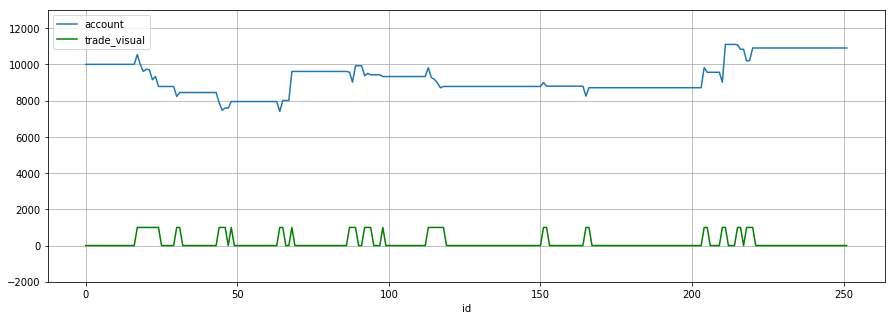

In [65]:
gold_account_long = get_performance(gold_clf_long, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [66]:
gold_account_long[gold_account_long['short'] == 1].gains.sum()

0.0

In [67]:
gold_account_long[gold_account_long['long'] == 1].gains.sum()

903.500000000004

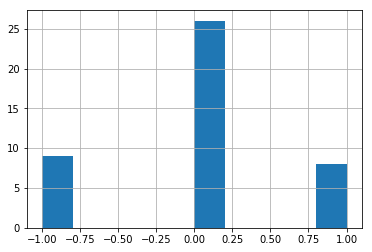

In [68]:
gold_account_long[gold_account_long['long'] == 1].label.hist()

In [69]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16; OpenJDK Runtime Environment (build 11.0.1+13-Ubuntu-2ubuntu1); OpenJDK 64-Bit Server VM (build 11.0.1+13-Ubuntu-2ubuntu1, mixed mode, sharing)
  Starting server from /home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpw_r9cxje
  JVM stdout: /tmp/tmpw_r9cxje/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmpw_r9cxje/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_martin_wgrhe3
H2O cluster total nodes:,1
H2O cluster free memory:,2.389 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [70]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long.csv")
test = h2o.import_file("data/gold_pca_long_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190125_083729_model_1,0.515834,0.886023,0.494915,0.523918,0.27449
DeepLearning_1_AutoML_20190125_083729,0.513637,0.702446,0.492057,0.488746,0.238873
StackedEnsemble_BestOfFamily_AutoML_20190125_083729,0.504286,0.615973,0.498511,0.460857,0.212389
StackedEnsemble_AllModels_AutoML_20190125_083729,0.495817,0.616534,0.5,0.461122,0.212633
GBM_1_AutoML_20190125_083729,0.480433,0.652629,0.499702,0.475743,0.226332
DeepLearning_grid_1_AutoML_20190125_083729_model_3,0.476121,1.21068,0.5,0.570075,0.324986
GLM_grid_1_AutoML_20190125_083729_model_1,0.475633,0.616029,0.498809,0.46088,0.21241
GBM_5_AutoML_20190125_083729,0.475546,0.635221,0.499107,0.469244,0.22019
DeepLearning_grid_1_AutoML_20190125_083729_model_4,0.471426,0.892142,0.496292,0.530595,0.281531
GBM_grid_1_AutoML_20190125_083729_model_2,0.47082,1.38224,0.5,0.573881,0.329339


deeplearning prediction progress: |███████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5332374710>]],
      dtype=object)

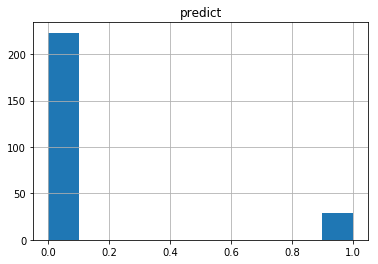

In [94]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

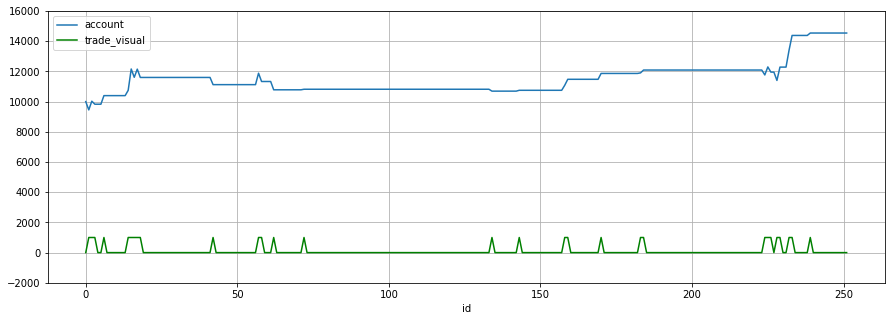

In [95]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [76]:
from sklearn.metrics import f1_score

In [92]:
from sklearn.metrics import confusion_matrix

df = gold_account[['label', 'trade']]
f1_score(df.label.map(lambda x: 0 if x < 0 else x).values, df.trade.values)

0.2439024390243903

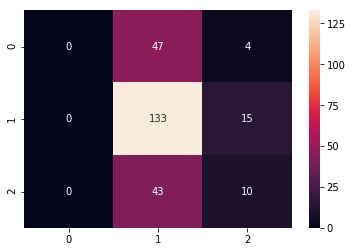

In [87]:
sns.heatmap(confusion_matrix(df['label'], df['trade']), annot=True, fmt="d")

In [90]:
gold_account['stop_loss'].sum()

6

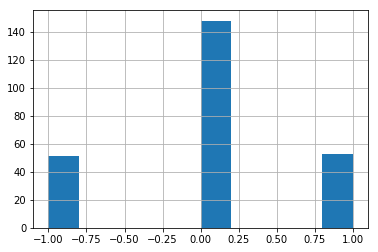

In [86]:
df['label'].hist()

In [96]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short.csv")
test = h2o.import_file("data/gold_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190125_093732_model_3,0.522961,0.605381,0.489737,0.455469,0.207452
GLM_grid_1_AutoML_20190125_093732_model_1,0.522819,0.605119,0.498007,0.455322,0.207318
GBM_1_AutoML_20190125_093732,0.515063,0.635076,0.49613,0.46791,0.21894
DRF_1_AutoML_20190125_093732,0.514947,0.689086,0.49138,0.479041,0.229481
StackedEnsemble_BestOfFamily_AutoML_20190125_093732,0.513376,0.606143,0.5,0.455799,0.207753
GBM_2_AutoML_20190125_093732,0.512809,0.642079,0.498945,0.470887,0.221734
GBM_5_AutoML_20190125_093732,0.510916,0.61953,0.487158,0.461773,0.213235
GBM_grid_1_AutoML_20190125_093732_model_5,0.509696,0.606287,0.499707,0.455878,0.207825
StackedEnsemble_AllModels_AutoML_20190125_093732,0.507835,0.606594,0.5,0.456006,0.207942
GBM_grid_1_AutoML_20190125_093732_model_4,0.505761,0.605885,0.49314,0.455691,0.207654


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5332237978>]],
      dtype=object)

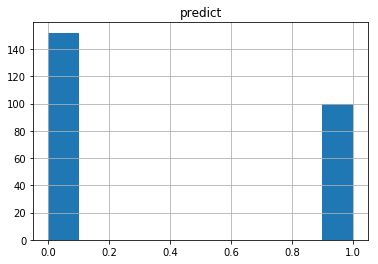

In [99]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

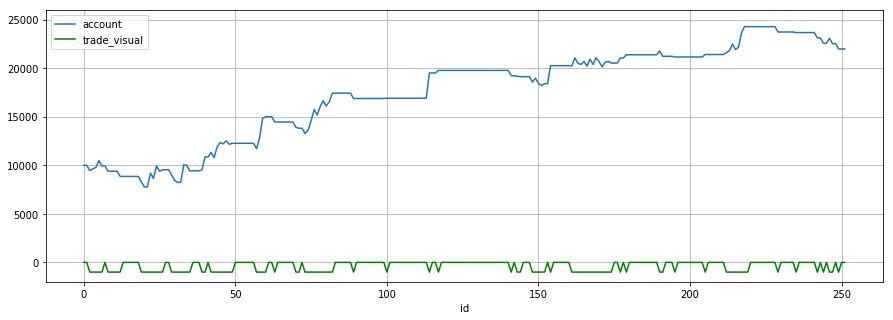

In [100]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [106]:
df = gold_account[['label', 'trade']]
f1_score(df.label.map(lambda x: 1 if x == -1 else 0).values, df.trade.map(lambda x: 1 if x == -1 else 0).values)

0.3178807947019867

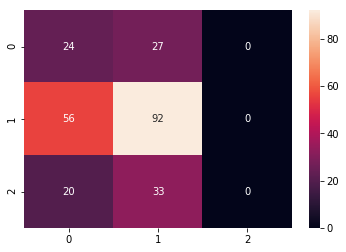

In [103]:
sns.heatmap(confusion_matrix(df['label'], df['trade']), annot=True, fmt="d")

In [110]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short.csv")
test = h2o.import_file("data/corn_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_5_AutoML_20190125_103642,0.575199,0.606448,0.470927,0.455987,0.207924
StackedEnsemble_BestOfFamily_AutoML_20190125_103642,0.574759,0.60334,0.458423,0.454765,0.206811
StackedEnsemble_AllModels_AutoML_20190125_103642,0.574216,0.603561,0.463249,0.454899,0.206933
GBM_2_AutoML_20190125_103642,0.562677,0.626663,0.478106,0.464538,0.215796
DeepLearning_grid_1_AutoML_20190125_103642_model_4,0.557595,0.850252,0.471869,0.508786,0.258863
GBM_grid_1_AutoML_20190125_103642_model_3,0.553811,0.607204,0.478323,0.456531,0.208421
DeepLearning_grid_1_AutoML_20190125_103642_model_3,0.551589,1.19679,0.5,0.539426,0.290981
GBM_4_AutoML_20190125_103642,0.551143,0.64835,0.48439,0.471568,0.222376
GBM_1_AutoML_20190125_103642,0.55104,0.627312,0.48658,0.464581,0.215836
DRF_1_AutoML_20190125_103642,0.550861,0.65395,0.499511,0.467794,0.218832


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53322690f0>]],
      dtype=object)

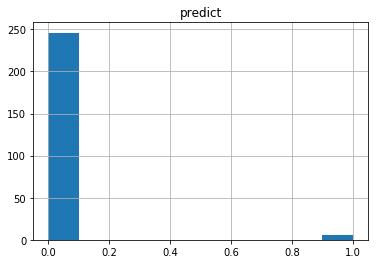

In [111]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

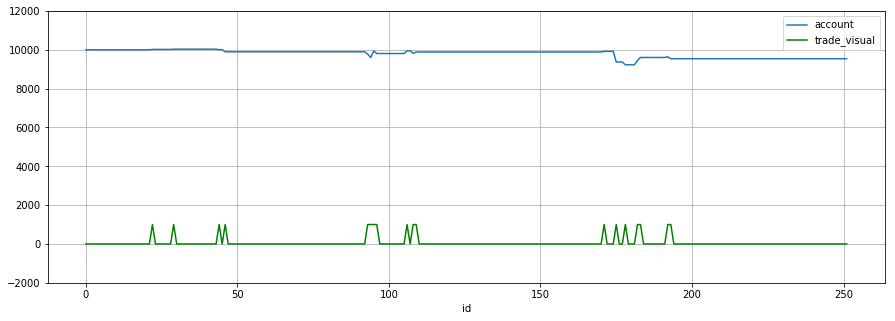

In [116]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [113]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long.csv")
test = h2o.import_file("data/corn_pca_long_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# The leader model is stored here
# aml.leader

# If you need to generate predictions on a test set, you can make
# predictions directly on the `"H2OAutoML"` object, or on the leader
# model object directly

# preds = aml.predict(test)

# or:
# preds = aml.leader.predict(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190125_104458,0.541889,0.638467,0.493926,0.469991,0.220891
StackedEnsemble_BestOfFamily_AutoML_20190125_104458,0.539559,0.617247,0.497506,0.461649,0.21312
GBM_4_AutoML_20190125_104458,0.538501,0.660494,0.481892,0.477432,0.227941
GBM_grid_1_AutoML_20190125_104458_model_1,0.537829,0.617336,0.481458,0.461677,0.213146
GBM_grid_1_AutoML_20190125_104458_model_3,0.536948,0.6172,0.471338,0.461612,0.213085
GBM_5_AutoML_20190125_104458,0.536138,0.626498,0.495012,0.465753,0.216926
DeepLearning_grid_1_AutoML_20190125_104458_model_1,0.535694,1.87882,0.5,0.55167,0.30434
GBM_3_AutoML_20190125_104458,0.535341,0.649682,0.492681,0.47458,0.225226
StackedEnsemble_AllModels_AutoML_20190125_104458,0.533716,0.618181,0.47568,0.462098,0.213534
DeepLearning_grid_1_AutoML_20190125_104458_model_2,0.530435,3.27328,0.5,0.614007,0.377005


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5332258160>]],
      dtype=object)

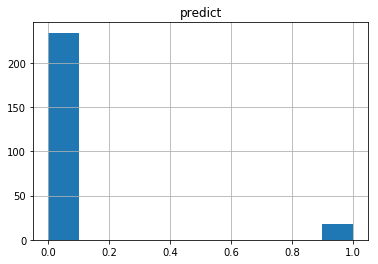

In [114]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

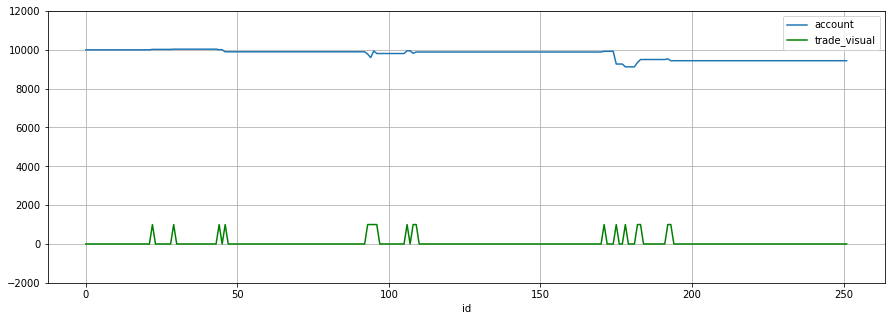

In [115]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [117]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long.csv")
test = h2o.import_file("data/coffee_pca_long_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_4_AutoML_20190125_105522,0.524811,0.687303,0.498704,0.493061,0.243109
DeepLearning_1_AutoML_20190125_105522,0.524629,0.740307,0.484504,0.505357,0.255386
GBM_1_AutoML_20190125_105522,0.520264,0.677614,0.497395,0.489861,0.239964
DeepLearning_grid_1_AutoML_20190125_105522_model_3,0.517124,1.22612,0.5,0.573574,0.328987
DeepLearning_grid_1_AutoML_20190125_105522_model_4,0.515554,0.796525,0.488514,0.511831,0.261971
StackedEnsemble_BestOfFamily_AutoML_20190125_105522,0.514161,0.653042,0.488447,0.479817,0.230225
GBM_5_AutoML_20190125_105522,0.513988,0.661591,0.5,0.483463,0.233737
GBM_2_AutoML_20190125_105522,0.513774,0.68268,0.499028,0.492165,0.242226
StackedEnsemble_AllModels_AutoML_20190125_105522,0.509175,0.653509,0.5,0.480038,0.230436
GBM_3_AutoML_20190125_105522,0.506102,0.690857,0.499028,0.495451,0.245471


gbm prediction progress: |████████████████████████████████████████████████| 100%


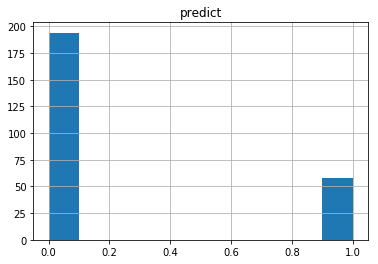

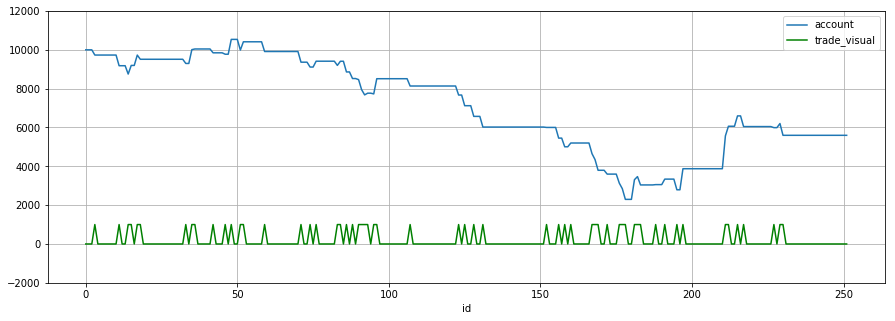

In [118]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [119]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short.csv")
test = h2o.import_file("data/coffee_pca_short_test.csv")

# Identify predictors and response
# model.fit(X, y, validation_data=(X_test, y_test), batch_size=10, epochs=10, callbacks=[checkpointer])
x = train.columns
y = "C81"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=600, seed=1234)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_1_AutoML_20190125_110503,0.528993,0.734009,0.486837,0.505455,0.255485
DeepLearning_grid_1_AutoML_20190125_110503_model_4,0.515416,0.828562,0.494504,0.526015,0.276692
GBM_grid_1_AutoML_20190125_110503_model_2,0.514271,1.41535,0.5,0.58845,0.346273
GBM_5_AutoML_20190125_110503,0.514097,0.672301,0.5,0.489065,0.239185
StackedEnsemble_BestOfFamily_AutoML_20190125_110503,0.513911,0.663081,0.499217,0.484892,0.23512
XRT_1_AutoML_20190125_110503,0.509603,0.694445,0.497432,0.498639,0.248641
DeepLearning_grid_1_AutoML_20190125_110503_model_2,0.509439,6.37707,0.5,0.656015,0.430356
StackedEnsemble_AllModels_AutoML_20190125_110503,0.509323,0.663662,0.499551,0.485176,0.235395
DRF_1_AutoML_20190125_110503,0.509136,0.697951,0.49191,0.500152,0.250152
GBM_1_AutoML_20190125_110503,0.506071,0.695037,0.5,0.498238,0.248241


deeplearning prediction progress: |███████████████████████████████████████| 100%


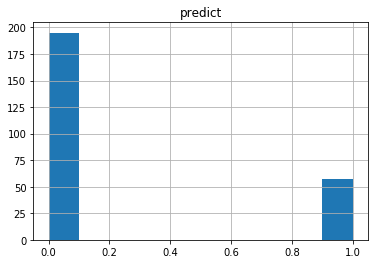

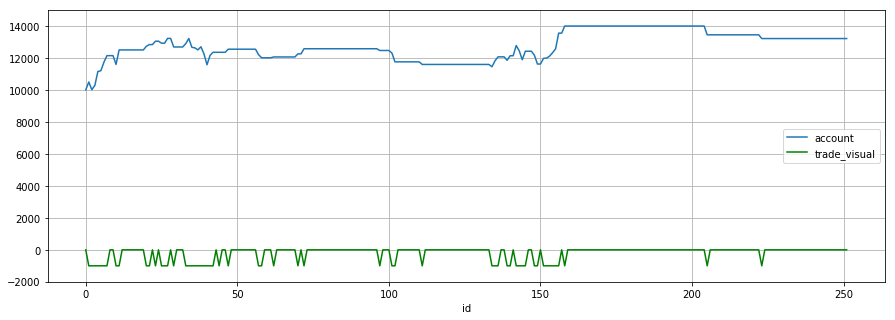

In [120]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [93]:
# %%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)
X_test = pca_transform(corn_test, corn_pca)

y = gold_label_train
y_test = gold_label_test

y = np.array(list(map(create_target, y.values)))
y_test = np.array(list(map(create_target, y_test.values)))

Train on 1930 samples, validate on 483 samples
Epoch 1/20
1930/1930 [==============================] - 0s 214us/step - loss: 7585335327808.7295 - precision: 0.3124 - val_loss: 843398301106.6169 - val_precision: 0.2981
Epoch 2/20
1930/1930 [==============================] - 0s 19us/step - loss: 291586916075.5731 - precision: 0.3124 - val_loss: 23971419680.8613 - val_precision: 0.2981
Epoch 3/20
1930/1930 [==============================] - 0s 21us/step - loss: 16840229365.7202 - precision: 0.3124 - val_loss: 5988083446.9896 - val_precision: 0.2981
Epoch 4/20
1930/1930 [==============================] - 0s 20us/step - loss: 2566351158.9637 - precision: 0.3124 - val_loss: 209472894.6087 - val_precision: 0.2981
Epoch 5/20
1930/1930 [==============================] - 0s 22us/step - loss: 75985194.8313 - precision: 0.3124 - val_loss: 12958947.1781 - val_precision: 0.2981
Epoch 6/20
1930/1930 [==============================] - 0s 20us/step - loss: 6077619.1275 - precision: 0.3124 - val_loss: 7

In [258]:
input_shape = 90
num_classes = 3

# Define a model
model = Sequential()  
model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

opt = Nadam(lr=0.002)

In [259]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_acc',
                               verbose=1, save_best_only=True,
                               save_weights_only=True)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=1, epochs=10, callbacks=[checkpointer])

model.summary()

Train on 1933 samples, validate on 484 samples
Epoch 1/10
1933/1933 [==============================] - 16s 8ms/step - loss: 734507634.4684 - acc: 0.3901 - val_loss: nan - val_acc: 0.3781

Epoch 00001: val_acc improved from -inf to 0.37810, saving model to saved_models/weights.corn.hdf5
Epoch 2/10
1933/1933 [==============================] - 11s 6ms/step - loss: 35611.2502 - acc: 0.3916 - val_loss: nan - val_acc: 0.3368

Epoch 00002: val_acc did not improve from 0.37810
Epoch 3/10
1933/1933 [==============================] - 7s 4ms/step - loss: 9560467.3102 - acc: 0.3916 - val_loss: nan - val_acc: 0.3678

Epoch 00003: val_acc did not improve from 0.37810
Epoch 4/10
1933/1933 [==============================] - 7s 4ms/step - loss: 28431686.8999 - acc: 0.3916 - val_loss: nan - val_acc: 0.4029

Epoch 00004: val_acc improved from 0.37810 to 0.40289, saving model to saved_models/weights.corn.hdf5
Epoch 5/10
1933/1933 [==============================] - 7s 4ms/step - loss: 25114517.3921 - acc: 

In [260]:
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_long = model

[0. 1.]
[-1  0  1]
No trade  10000 0 0.0 [    0.  17650.  17737.5 17612.5 17650.      0.     87.5    37.5]
Acc  10000
No trade  10000 0 0.0 [  -95.  17650.  17675.  17512.5 17550.      0.     25.    137.5]
Acc  10000
No trade  10000 0 0.0 [   23.75 17537.5  17612.5  17512.5  17562.5      0.      75.      25.  ]
Acc  10000
Long  10000 1 -1.0 [-1.66250e+02  1.75375e+04  1.75750e+04  1.73375e+04  1.73625e+04
 -1.00000e+00  3.75000e+01  2.00000e+02]
Acc  9832.25
No trade  9832.25 0 0.0 [7.12500e+01 1.73750e+04 1.75000e+04 1.73625e+04 1.74500e+04 0.00000e+00
 1.25000e+02 1.25000e+01]
Acc  9832.25
No trade  9832.25 0 0.0 [1.18750e+01 1.74375e+04 1.75000e+04 1.74000e+04 1.74500e+04 0.00000e+00
 6.25000e+01 3.75000e+01]
Acc  9832.25
No trade  9832.25 0 0.0 [-1.18750e+01  1.74500e+04  1.75250e+04  1.74000e+04  1.74375e+04
  0.00000e+00  7.50000e+01  5.00000e+01]
Acc  9832.25
Long  9832.25 1 0.0 [ -118.75 17437.5  17500.   17275.   17312.5      0.      62.5    162.5 ]
Acc  9712.0
No trade  9712.

Short  11007.0 -1 1.0 [3.44375e+02 1.81000e+04 1.86500e+04 1.80125e+04 1.84625e+04 1.00000e+00
 5.50000e+02 8.75000e+01]
Stop loss hit!
Acc  10707.0
Short  10707.0 -1 1.0 [2.25625e+02 1.84500e+04 1.87000e+04 1.84250e+04 1.86875e+04 1.00000e+00
 2.50000e+02 2.50000e+01]
Acc  10479.875
No trade  10479.875 0 1.0 [2.49375e+02 1.86500e+04 1.89250e+04 1.85875e+04 1.89125e+04 1.00000e+00
 2.75000e+02 6.25000e+01]
Acc  10479.875
No trade  10479.875 0 0.0 [-9.50000e+01  1.88625e+04  1.88750e+04  1.86750e+04  1.87625e+04
  0.00000e+00  1.25000e+01  1.87500e+02]
Acc  10479.875
No trade  10479.875 0 0.0 [  -35.625 18750.    18812.5   18662.5   18712.5       0.       62.5
    87.5  ]
Acc  10479.875
No trade  10479.875 0 0.0 [-1.06875e+02  1.86500e+04  1.86625e+04  1.84750e+04  1.85375e+04
  0.00000e+00  1.25000e+01  1.75000e+02]
Acc  10479.875
No trade  10479.875 0 -1.0 [-1.6625e+02  1.8525e+04  1.8550e+04  1.8300e+04  1.8350e+04 -1.0000e+00
  2.5000e+01  2.2500e+02]
Acc  10479.875
No trade  10479.

(0, 13000.0)

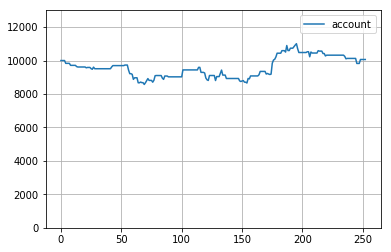

In [261]:
corn_account_long = get_performance(corn_clf_long, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss=300)
ax1 = corn_account_long[['account']].plot(grid=True)
ax1.set_ylim(0, get_round_ceiling(corn_account_long.account))

In [264]:
corn_account_long[corn_account_long['long'] == 1].gains.sum()

-1036.0

In [266]:
corn_account_long[corn_account_long['short'] == 1].gains.sum()

1098.25

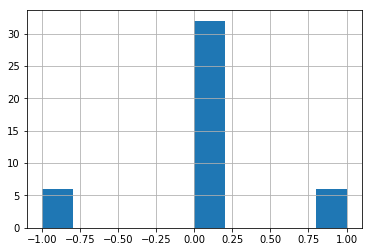

In [265]:
corn_account_long[corn_account_long['long'] == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f0977fda0>,
      dtype=object)

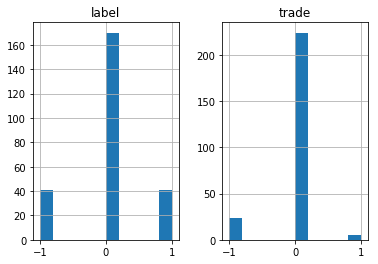

In [257]:
corn_account_long[['trade', 'label']].hist()

In [98]:
# %%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)
X_test = pca_transform(coffee_test, coffee_pca)
y = list(map(lambda x: 1 if x < 0 else 0, coffee_label_test))
model = Sequential()  
model.add(Dense(64, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2)

model.summary()

coffee_clf_long = model
# coffee_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])

ValueError: Error when checking target: expected activation_7 to have shape (2,) but got array with shape (3,)

In [111]:
coffee_account_long = get_performance(coffee_clf_long, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], corn_validate, coffee_label_validate, short=False, stop_loss=1000, vector=True)
ax1 = coffee_account_long[['account']].plot(grid=True)
ax1.set_ylim(0, get_round_ceiling(coffee_account_long.account))

NameError: name 'coffee_clf_long' is not defined

In [87]:
coffee_account_long.head(10)

,account,trade,label,short,long,stop_loss,gains
0,10000.0000,0.0,0.0,0,0,0,0.0000
1,9000.0000,1.0,-1.0,0,1,1,-1000.0000
2,9479.4375,1.0,1.0,0,1,0,479.4375
3,9210.7500,1.0,0.0,0,1,0,-268.6875
4,8210.7500,1.0,-1.0,0,1,1,-1000.0000
5,7210.7500,1.0,0.0,0,1,1,-1000.0000
6,6674.8750,1.0,-1.0,0,1,0,-535.8750
7,6263.6875,1.0,-1.0,0,1,0,-411.1875
8,6066.2500,1.0,0.0,0,1,0,-197.4375
9,5583.8125,1.0,-1.0,0,1,0,-482.4375


In [88]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

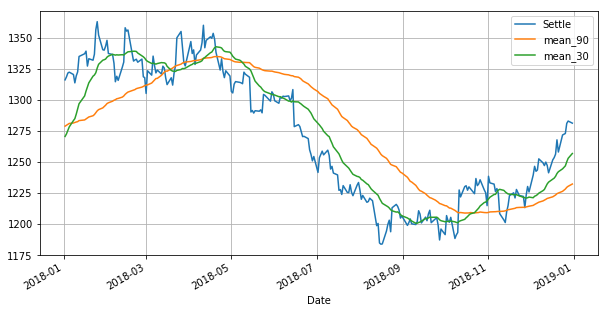

In [89]:
gold = mean_calculation(gold, 90, 30)
gold[['Settle', 'mean_90', 'mean_30']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)

In [90]:
# dow_amount = 10000/dow[dow.index == '2018-01-01'].Settle
# print(dow.loc[(dow.index >= '2018-01-01') & (dow.index < '2018-01-02')].Settle)
# print(dow_amount)
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]
# dow = dow.loc[(dow.index <= '2018-12-31')]
# gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}).head()

In [91]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [92]:
nasdaq_amount

1.5349783184312522

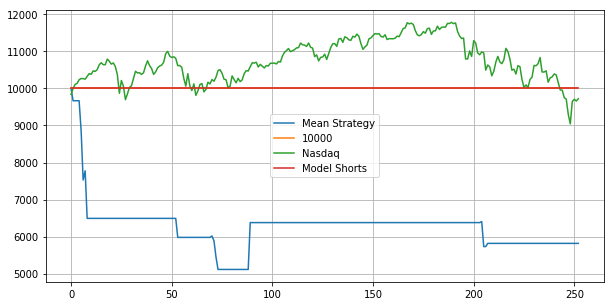

In [93]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           gold_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5), grid=True)

In [94]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9837.292298
1,9667.5,10000,10000.000000
2,9667.5,10000,10107.064738
3,9667.5,10000,10136.229326
4,9667.5,10000,10234.851683


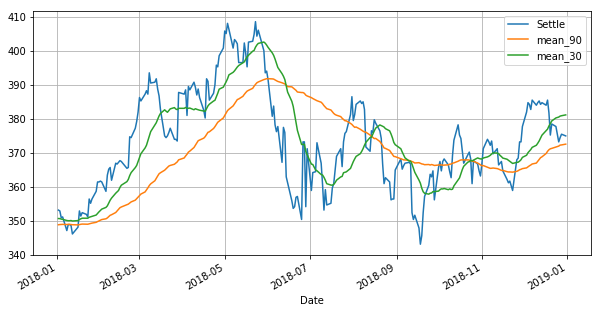

In [95]:
corn = mean_calculation(corn, 90, 30)
corn[['Settle', 'mean_90', 'mean_30']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

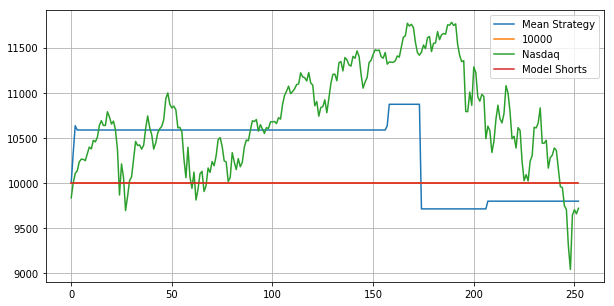

In [96]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           corn_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']]], 
          axis=1).plot(figsize=(10,5), grid=True)

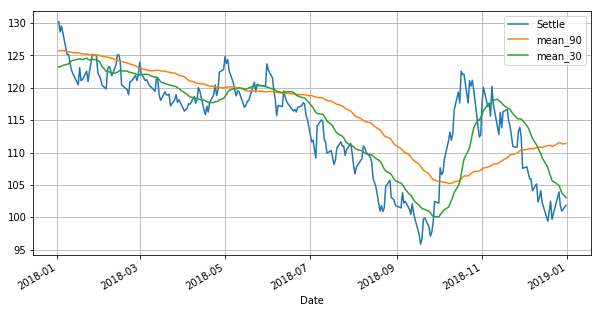

In [97]:
coffee = mean_calculation(coffee, 90, 30)
coffee[['Settle', 'mean_90', 'mean_30']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

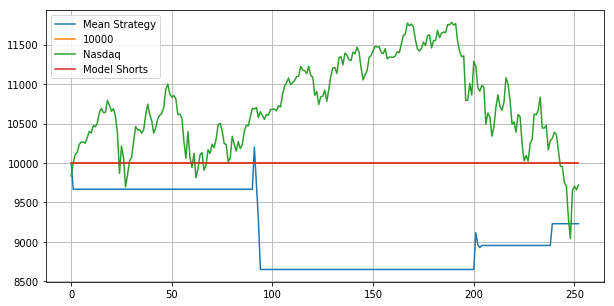

In [98]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           coffee_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5), grid=True)